In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [2]:
from scipy.spatial.distance import pdist, squareform
def VAT(R):
    R = np.array(R)
    N, M = R.shape
    if N != M:
        R = squareform(pdist(R))
    J = list(range(0, N))
    
    y = np.max(R, axis=0)
    i = np.argmax(R, axis=0)
    j = np.argmax(y)
    y = np.max(y)
    
    I = i[j]
    del J[I]
    
    y = np.min(R[I,J], axis=0)
    j = np.argmin(R[I,J], axis=0)
    I = [I, J[j]]
    J = [e for e in J if e != J[j]]
    C = [1,1]

    for r in range(2, N-1):
        y = np.min(R[I,:][:,J], axis=0)
        i = np.argmin(R[I,:][:,J], axis=0)
        j = np.argmin(y)
        y = np.min(y)
        I.extend([J[j]])
        J = [e for e in J if e != J[j]]
        C.extend([i[j]])

    y = np.min(R[I,:][:,J], axis=0)
    i = np.argmin(R[I,:][:,J], axis=0)

    I.extend(J)
    C.extend(i)

    RI = list(range(N))
    for idx, val in enumerate(I):
        RI[val] = idx

    RV = R[I,:][:,I]
    return RV.tolist(), C, I


def entropy(probs):
    probs = probs.loc[probs>0]
    #probs should not equal to 0
    return -probs.dot(np.log2(probs))


def mutual_info(df):
    
    Hx = entropy(df.iloc[:,0].value_counts(normalize=True, sort=False))
    Hy = entropy(df.iloc[:,1].value_counts(normalize=True, sort=False))
    
    counts = df.groupby(list(df.columns.values)).size()
    
    probs = counts/ counts.values.sum()
    H_xy = entropy(probs)
    

    # Mutual Information
    I_xy = Hx + Hy - H_xy
    MI = I_xy
    NMI = I_xy/min(Hx,Hy) #I_xy/np.sqrt(H_x*H_y)
    
    return {'H_'+list(df)[0]:Hx,'H_'+list(df)[1]:Hy,'MI':MI,'NMI':NMI} 


In [3]:
food =  pd.read_csv("food_nutrient_2011_13_AHS.csv", header=0,low_memory=False)

In [4]:
##Question 1


###1a
data = food.iloc[:,4:]
#use iloc function to retrive part of the original dataframe


###1b
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
#set the standardized value with mean 0 and variance 1
scaler.fit(data)
foodscaled = pd.DataFrame(scaler.transform(data))
foodscaled.columns = list(data.columns)
#set the column name of foodscaled with the column name of data
foodscaled

###1c
print('*'*3)
print('Q1.c: foodscaled matrix details')
print("Number of rows:", foodscaled.shape[0])
print("Number of columns:", foodscaled.shape[1])
print("Min:", round(foodscaled.values.min(), 1))
print("Max:", round(foodscaled.values.max(), 1))
print("Mean:", round(foodscaled.values.mean(), 1))
print("Standard Deviation:", round(foodscaled.values.std(), 1))
print('*'*3)

***
Q1.c: foodscaled matrix details
Number of rows: 5740
Number of columns: 53
Min: -2.0
Max: 75.8
Mean: 0.0
Standard Deviation: 1.0
***


/Users/abigail/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/abigail/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  del sys.path[0]


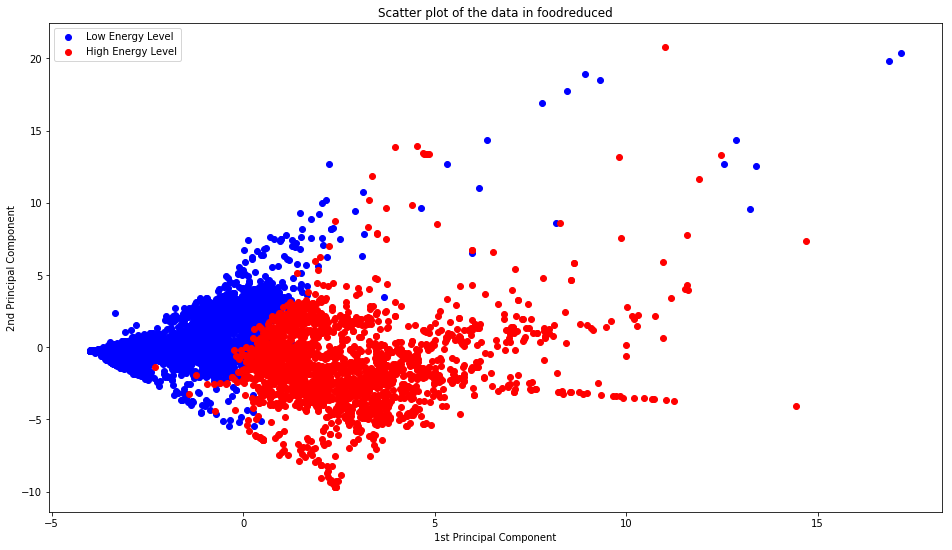

In [5]:
#Question 2


###2a
foodscaled['EnergyLevel'] = np.where(food['Energy, with dietary fibre (kJ)']>1000, '1', '0')

###2b
scalepca = PCA(n_components=2)
foodreduced = scalepca.fit_transform(foodscaled)

###2c
reducedata = pd.DataFrame(foodreduced)
#convert array into dataframe
reducedata.columns = foodscaled.columns[:2]
#set the column name
reducedata["EnergyLevel"] = foodscaled['EnergyLevel']
#insert EnergyLevel column
low = reducedata[reducedata["EnergyLevel"]=='0']
high = reducedata[reducedata["EnergyLevel"]=='1']
plt.figure(figsize=(16,9))
plt.scatter(low.iloc[:,0], low.iloc[:,1], color='blue')
plt.scatter(high.iloc[:,0], high.iloc[:,1], color='red')
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.legend(['Low Energy Level', 'High Energy Level'])
plt.title("Scatter plot of the data in foodreduced")
plt.show()

Question 2d answer here



It can be seen from the above graph that it does not show two (or more) clear separated clusters, if we ignore the color for energy level, most of the data are located around (0,0), but with the color, it shows that data with low energy level tend to have lower "Energy, with dietary fibre" (1st principle component) compared with data have high energy level. If we treat data with different energy levels as two separate clusters, the graph illustrates that both clusters have several outliers. Therefore it is reasonable to conclude that the first principle component is important when we separate data into clusters. Moreover, through the code below, these two components we selected do not explain much variance (although they may be attributes with the largest variance amoung 57 attributes), so they are not very effective to help us determine clusters for this dataset. The advantage of this dataset to use PCA is that it can reduce the dimension of the whole dataset (from 57 to 2). If we choose the correct components, it can help us to gain clear insight about the distribution of whole data in a much more suffcient way. The disadvantage is that there are too many attributes in this dataset which makes it very hard for us to select the principle components that can explain the highest proportion of variability, and since the large number of attributes, they may all have the similar variance.

In [6]:
print("Variance explained by each PC",scalepca.explained_variance_ratio_)

Variance explained by each PC [0.134789   0.11819063]


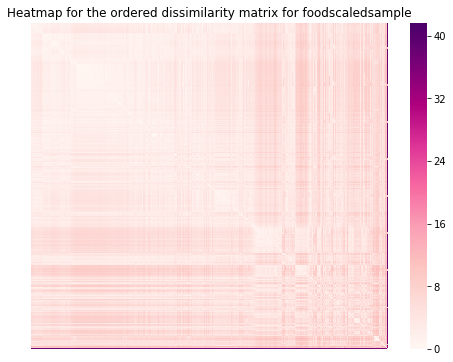

In [7]:
#Question 3


###3a
survey = food.loc[:, 'Survey ID']
#use loc[] to get the 'Survey ID' column, then use astype() function to change its type to string
surveystr = survey.astype('str')
food["Survey ID"] = surveystr
surveyseries = pd.Series(surveystr)
category = surveyseries.str.slice(stop=2)
#get the value which need to be stored in the new column "Food category"
foodscaled["Food category"] = category
foodscaled
###3b
foodscaledsample = foodscaled.loc[foodscaled['Food category'].isin(['13', '20', '24'])]

###3c
VAT(foodscaledsample.iloc[:, :foodscaledsample.shape[1]-1])


###3d
RV, C, I = VAT(foodscaledsample.iloc[:, :foodscaledsample.shape[1]-1])
plt.figure(figsize=(8,6))
x=sns.heatmap(RV,cmap='RdPu',xticklabels=False,yticklabels=False)
plt.title("Heatmap for the ordered dissimilarity matrix for foodscaledsample")
plt.show()
#use sequential colormaps with light color

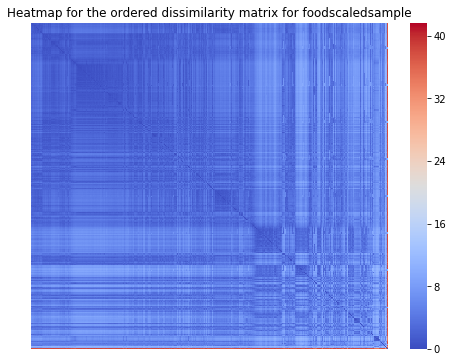

In [8]:
#use sequential colormaps with dark color
RV, C, I = VAT(foodscaledsample.iloc[:, :foodscaledsample.shape[1]-1])
plt.figure(figsize=(8,6))
x=sns.heatmap(RV,cmap='coolwarm',xticklabels=False,yticklabels=False)
plt.title("Heatmap for the ordered dissimilarity matrix for foodscaledsample")
plt.show()

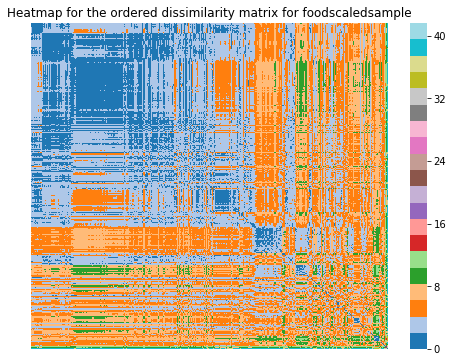

In [9]:
#figure 3
#use qualitative colors with clear color contrast
RV, C, I = VAT(foodscaledsample.iloc[:, :foodscaledsample.shape[1]-1])
plt.figure(figsize=(8,6))
x=sns.heatmap(RV,cmap='tab20',xticklabels=False,yticklabels=False)
plt.title("Heatmap for the ordered dissimilarity matrix for foodscaledsample")
plt.show()


Question 3e here


As can be seen from the heat maps above with different colors, there might be 2 clusters for this dataset.
It is expected since from the scatter plot in 2c it shows that data with the same energy level tend to form 
the same cluster, which means that there are two clusters in this dataset. 

The varying usefulness of this visualisations due to different color maps is because of the property of the data values. If the data value is discrete or continuous in a small range, it is better to use qualitative colormaps with clear color contrast to amplify the difference; if the data value is in large range, sequential colormaps would be a good choice since it can reflect the exact value of each data in the heat map without amplifying the difference. In this situation, qualitative colormaps with clear color contrast (like figure 3) is the optimal choice since the data in foodscaledsample is scaled with 0 mean and unit variance, which is a small value range, so we need colormaps like "tab20" which are qualitative colormaps with clear color contrast to amplify the difference between each individial data. 

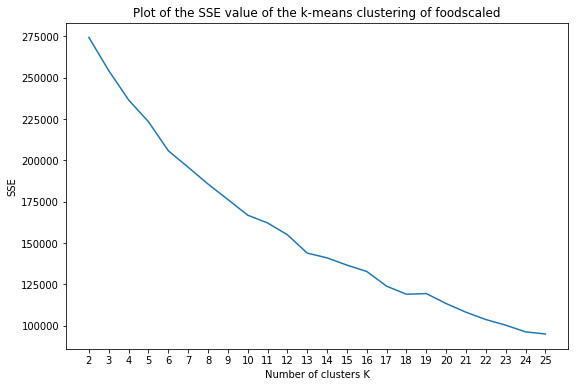

In [10]:
#Question 4

###4a 
sse = {}
for k in range(2, 26):
    kmeans = KMeans(n_clusters=k, random_state=100).fit(foodscaled.iloc[:, :foodscaled.shape[1]-2])
    sse[k] = kmeans.inertia_
    # Inertia: Sum of distances of samples to their closest cluster center
plt.figure(figsize=(9,6))
plt.plot(list(sse.keys()), list(sse.values()))
plt.title('Plot of the SSE value of the k-means clustering of foodscaled')
plt.xlabel("Number of clusters K")
plt.ylabel("SSE")
plt.xticks(np.arange(2, 26, step=1))
#start x label from 2
plt.show()

Question 4b answer here

The graph above shows a relative smooth line, it illustrates that as the number of clusters increasing, SSE tends to decrease to 0. The elbow in this graph is undefined, which is not expected, since the line is quite smooth and it is unclear to define the best value of k, which is contradict to the previous analysis. This may correspond to the heat maps in 3d which shows the unclear boundary between clusters.

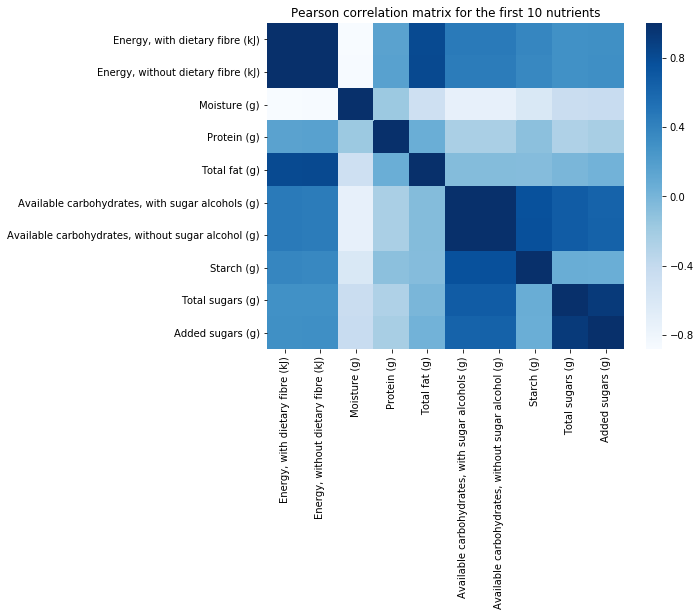

In [11]:
###Question 5


###5a
cordata = food.iloc[:,4:14]
corr = cordata.corr()
# retrive the 10 useful columns
plt.subplots(figsize=(8,6))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap="Blues")
plt.title("Pearson correlation matrix for the first 10 nutrients")
plt.show()

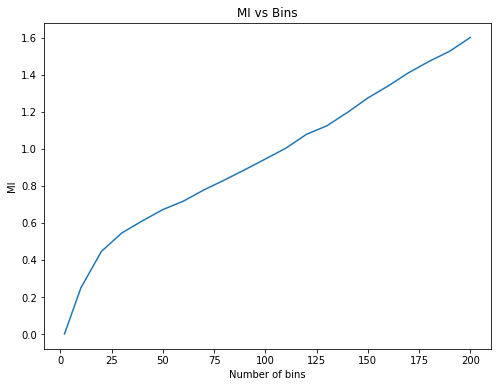

In [12]:
###5b code
bindata = food.loc[:,['Protein (g)', 'Energy, with dietary fibre (kJ)']]
protein = food.loc[:,['Protein (g)']]
energy = food.loc[:,['Energy, with dietary fibre (kJ)']]
protein.index
protein['2'] = pd.cut(food['Protein (g)'], 2)
energy['2'] = pd.cut(food['Energy, with dietary fibre (kJ)'], 2)


for i in range(10, 210, 10):
    protein[i] = pd.cut(food['Protein (g)'], i)
    energy[i] = pd.cut(food['Energy, with dietary fibre (kJ)'], i)
binlist = [2]
bins = protein['2']
binstable = pd.DataFrame(bins)
binstable['ene'] = energy['2']
MI = mutual_info(binstable)
MIlist = [MI['MI']]

for j in range(10, 210, 10):
    bintable = protein[j]
    table = pd.DataFrame(bintable)
    table['ene'] = energy[j]
    table.columns = table.columns.map(str)
    MI = mutual_info(table)
    binlist.append(j)
    MIlist.append(MI['MI'])
binlist
MIlist
miplot = pd.DataFrame(binlist)
miplot['MI'] = MIlist
miplot.columns = ['Bin', 'MI']
plt.figure(figsize=(8,6))
plt.plot(miplot['Bin'], miplot["MI"])
plt.xlabel('Number of bins')
plt.ylabel('MI')
plt.title('MI vs Bins')
plt.show()

At first the MI function provided above did not work for all number of bins, however, after editing the code of that function, it finally works. But before that, I imported another function which can also calculate MI, and the difference between this two functions is that the function I imported uses natural log and the function provided uses log2. Since the input of mutual_info need to be a dataframe which may make the code complicated, for the following analysis and questions, I choose to use mutual_info_score which I imported. It will not influence the data analysis, only the MI values will be slightly different.

In [13]:
#this is just the repetition of 5b by using different function
#to prove that the analysis of data will not be influenced, only the values will be different

from sklearn.metrics import mutual_info_score

binlist = [2]
bins = protein['2']
binstable = pd.DataFrame(bins)
binstable['ene'] = energy['2']
MI = mutual_info(binstable)
MIlist = [MI['MI']]
#first calculate the mutual information for 2 bins

for j in range(10, 210, 10):
    a = pd.cut(food['Protein (g)'], j)
    b = pd.cut(food['Energy, with dietary fibre (kJ)'], j)
    MI = mutual_info_score(a, b, contingency=None)
    MIlist.append(MI)
    binlist.append(j)
#calculate MI for different number of bins and put them into a list

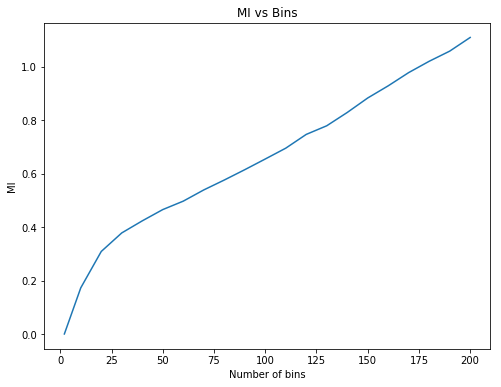

In [14]:
miplot = pd.DataFrame(binlist)
miplot['MI'] = MIlist
miplot.columns = ['Bin', 'MI']
plt.figure(figsize=(8,6))
plt.plot(miplot['Bin'], miplot["MI"])
plt.xlabel('Number of bins')
plt.ylabel('MI')
plt.title('MI vs Bins')
plt.show()

Question 5b comment here

As can be seen from the above plots, as the number of bins increases, the value of MI also increases.
It is reasonable since as the whole dataset be devided into the increasing number of clusters, the similarity between each individial data in the same cluster will increasing, which will lead to the increasing of mutual information value. 

In [15]:
###5c code
#top10 correlation
print("Top-10 feature-pairs by Pearson correlation strength (highest to lowest with positive values):")
data.corr(method='pearson')
datapair = data.corr().unstack().sort_values().drop_duplicates()
datapair.sort_values(ascending = False)[1:11]
#find the datapair with respective correlation without duplicates, 
#then sort them in descending order, retrive the top 10

Top-10 feature-pairs by Pearson correlation strength (highest to lowest with positive values):


Vitamin E (mg)                                    Alpha-tocopherol (mg)                                 0.999528
Energy, with dietary fibre (kJ)                   Energy, without dietary fibre (kJ)                    0.998608
Beta-carotene (µg)                                Provitamin A (b-carotene equivalents) (µg)            0.995961
Available carbohydrates, with sugar alcohols (g)  Available carbohydrates, without sugar alcohol (g)    0.995466
Free sugars (g)                                   Added sugars (g)                                      0.988894
Dietary folate equivalents  (µg)                  Total Folates  (µg)                                   0.985763
Linoleic acid (g)                                 Total polyunsaturated fat (g)                         0.973640
Folic acid  (µg)                                  Dietary folate equivalents  (µg)                      0.958112
Preformed vitamin A (retinol) (µg)                Vitamin A retinol equivalents (µg)            

In [16]:
print("Top-10 feature-pairs by Pearson correlation strength (highest to lowest with negative values):")
data.corr(method='pearson')
datapair = data.corr().unstack().sort_values().drop_duplicates()
datapair.sort_values(ascending = True)[0:10]

Top-10 feature-pairs by Pearson correlation strength (highest to lowest with negative values):


Moisture (g)   Energy, with dietary fibre (kJ)                      -0.881935
               Energy, without dietary fibre (kJ)                   -0.870074
               Available carbohydrates, with sugar alcohols (g)     -0.725461
               Available carbohydrates, without sugar alcohol (g)   -0.723102
               Starch (g)                                           -0.595786
Total fat (g)  Moisture (g)                                         -0.488719
Moisture (g)   Total sugars (g)                                     -0.447709
               Magnesium (Mg) (mg)                                  -0.437087
               Added sugars (g)                                     -0.427765
               Free sugars (g)                                      -0.427139
dtype: float64

I print out the top 10 feature pairs with the highest negative pearson correlation values since the strength of pearson correlation is determined by the absolute value of correlation. However, compare the above two lists, it is apparent that top 10 feature pairs with positive values are stronger than the feature pairs of negative pairs.

In [17]:
#top10 MI
print("Top-10 feature-pairs by Mutual Information, using 20 equal-width bins:")
datacopy = food.iloc[:,4:]
startlist = []
for i in range(datacopy.shape[1]):
    aname = datacopy.columns[i]
    a = pd.cut(datacopy[datacopy.columns[i]],20)
    for j in range(datacopy.shape[1]):
        bname = datacopy.columns[j]
        b = pd.cut(datacopy[datacopy.columns[j]],20)
        MI = mutual_info_score(a, b, contingency=None)
        #calculate MI for each combination of two attributes
        startlist.append((aname, bname, MI))
MIlist = []
for k in range(len(startlist)):
    if startlist[k][0] != startlist[k][1]:
        MIlist.append(startlist[k])
    else:
        MIlist = MIlist

MIlistdata = pd.DataFrame(MIlist)
columnname = ['attribute1', 'attribute2', 'MI']
MIlistdata.columns = columnname
top20 = MIlistdata.sort_values('MI', ascending = False)[:20]
#choose the top 20 MI values since there are two different combinations of two attributes which will have the same MI value
MI10list = top20.values.tolist()
top10 = []
for i in range(0, len(MI10list), 2):
    top10.append(MI10list[i])
top10MI = pd.DataFrame(top10)
top10MI.columns = columnname
order = list(range(1,11))
top10MI.index = order
top10MI

Top-10 feature-pairs by Mutual Information, using 20 equal-width bins:


,attribute1,attribute2,MI
1,"Energy, without dietary fibre (kJ)","Energy, with dietary fibre (kJ)",2.176656
2,"Available carbohydrates, with sugar alcohols (g)","Available carbohydrates, without sugar alcohol...",2.128525
3,"Energy, with dietary fibre (kJ)",Moisture (g),1.303228
4,"Energy, without dietary fibre (kJ)",Moisture (g),1.241447
5,Protein (g),Tryptophan (mg),0.942670
6,Added sugars (g),Free sugars (g),0.869117
7,Starch (g),"Available carbohydrates, without sugar alcohol...",0.763316
8,"Available carbohydrates, with sugar alcohols (g)",Starch (g),0.759307
9,Free sugars (g),Total sugars (g),0.678573
10,"Energy, with dietary fibre (kJ)",Total fat (g),0.664738


#Question 5c comment here

By comparing top10 correlation pairs and top10 MI pairs,it can be seen that there are only 3 pairs of attributes exist in both tables. This may because the Pearson correlation measures the linear relationship between two vairables, which means that whether the increasing of one variable will lead to the increasing or decreasing of the other; while mutual information measures how much information can we gain about one variable if we know the other, which will use the probability distribution of variables. Therefore, they are two different measurements that illustrate data information in different aspects, so there may not be many common feature pairs in these two tables. 

***
Q6.a: Train Test Split Results
X_train matrix: 4592 * 53
y_train labels: 4592
X_test matrix: 1148 * 53
y_test labels: 1148
***


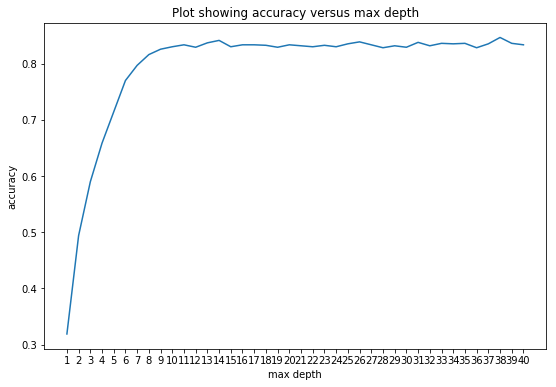

In [18]:
##Question 6


###6a

X_train, X_test, y_train, y_test = train_test_split(foodscaled.iloc[:,0:53], foodscaled['Food category'], test_size=0.2, train_size=0.8)
print('*'*3)
print('Q6.a: Train Test Split Results')
print('X_train matrix:', X_train.shape[0], '*', X_train.shape[1])
print('y_train labels:', y_train.shape[0])
print('X_test matrix:', X_test.shape[0], '*', X_test.shape[1])
print('y_test labels:', y_test.shape[0])
print('*'*3)

###6b
depth = []
accuracy = []
for i in range(1, 41):
    tree = DecisionTreeClassifier(criterion="entropy", max_depth=i)
    tree = tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    depth.append(i)
    accuracy.append(accuracy_score(y_test, y_pred))
plt.figure(figsize=(9,6))
plt.plot(depth, accuracy)
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.title('Plot showing accuracy versus max depth')
plt.xticks(np.arange(1, 41, step=1))
plt.show()

Question 6c comment here

As can be seen from the above graph, as the number of max depth increaseing, the accuracy of prediction is increasing, with the maximum accuracy approximate 1. This is because as the number of internal nodes of the decision tree is increasing, each data can be classified more accurately due to its characteristic, and allocated to the more suitable food category. So the accuracy score will increases as the max depth increases.
it seems that max depth which is greater or equal to 10 can be the optimal option for this dataset. 

In [19]:
#Question 7

###7a
neighbor1 = KNeighborsClassifier(n_neighbors=1)
a = neighbor1.fit(X_train,y_train)
trainpred = a.predict(X_train)
trainac1 = accuracy_score(y_train, trainpred)
testpred = a.predict(X_test)
testac1 = accuracy_score(y_test, testpred)
print('*'*3)
print('Q7a: Food category prediction using k-NN (k=1)')
print('Train accuracy:', round(100*trainac1, 1), '%')
print('Test accuracy:', round(100*testac1, 1), '%')
print('*'*3)

##7b
neighbor3 = KNeighborsClassifier(n_neighbors=3)
a = neighbor3.fit(X_train,y_train)
trainpred = a.predict(X_train)
trainac1 = accuracy_score(y_train, trainpred)
testpred = a.predict(X_test)
testac1 = accuracy_score(y_test, testpred)
print('*'*3)
print('Q7.b: Food category prediction using k-NN (k=3)')
print('Train accuracy:', round(100*trainac1, 1), '%')
print('Test accuracy:', round(100*testac1, 1), '%')
print('*'*3)


***
Q7a: Food category prediction using k-NN (k=1)
Train accuracy: 100.0 %
Test accuracy: 88.9 %
***
***
Q7.b: Food category prediction using k-NN (k=3)
Train accuracy: 93.4 %
Test accuracy: 88.2 %
***


Question 7c comment here

Question 7d comment here


#Question 7c comment

As can be seen from the above result, when number of neighbors = 1, both train accuracy and test accuracy are higher than the accuracy when k=3. This is because when k=1, there is only 1 nearest neighbor, so the data is simply assigned to the class of that single nearest neighbor, that's why the train accuracy for k=1 is 100% and test accuracy is also higher than k=3. When k=3, there are 3 nearest neighbors around one data, if this single data is a outlier or contains some errors, it could lead the data into the wrong nearest neighbor, which will decrease the accuracy for both train and test.

However, for both k=1 and k=3, train accuracy is higher than test accuracy.

#Question 7d comment

K-NN measures the distance between datas, and distance can be influenced by the measurement units of each features. So if the data of each features has different value ranges, it will significantly influence the neighbor-choosing during this algorithm. Therefore, if we scale all features' data (both train data and test data are contained) with the same mean and variance, all data will be in the same value range, which would increase the accuracy.

The solution to this problem is that if we can split the unscaled data into training set and testing set, then scaled the training and testing data separately, the accuracy may be more close to the actual values. 

In [ ]:
#Question 8 code


In [56]:
#Interaction term pairs f1*f2
foodtest = foodscaled.iloc[:,:-2]

for k in range(53):
    for j in range(k+1,54):
        f1f2 = []
        for i in range(5740):
            f1f2.append((foodtest.iloc[i,k]*foodtest.iloc[i,j]))
        foodtest[foodtest.columns[k]+' * '+foodtest.columns[j]] = f1f2

namelist = []
for i in range(foodtest.shape[1]):
    if len(foodtest.columns[i].split('*'))!=3:
        namelist.append(foodtest.columns[i])
test = pd.DataFrame()
for i in namelist:
    test[i]=foodtest[i]
test

test["Food category"]=foodscaled["Food category"]
# add the data of pairs of features f1 and f2 in foodscaled where data = f1 × f2 

multipleMI = []
for i in range(test.shape[1]-1):
    name = test.columns[i]
    label = test.columns[-1]
    a = test.iloc[:,i]
    b = test["Food category"]
    MI = mutual_info_score(a, b, contingency=None)
    multipleMI.append((name, label, MI))
#calculate MI between each feature pair with Food category

mulMIdata = pd.DataFrame(multipleMI)
columnname = ['feature','Food category','MI']
mulMIdata.columns = columnname
mulMI100 = mulMIdata.sort_values('MI', ascending = False)[:100]
#highest 100 MI between each feature pair with Food category

mul100feature = pd.DataFrame()
for name in mulMI100['feature']:
    mul100feature[name]=test[name]
mul100feature["Food category"] = test["Food category"]
#retain the value of top100 features

mulX_train, mulX_test, muly_train, muly_test = train_test_split(mul100feature.iloc[:, :mul100feature.shape[1]-1], mul100feature['Food category'], test_size=0.2, train_size=0.8)

neighbor1 = KNeighborsClassifier(n_neighbors=1)
a = neighbor1.fit(mulX_train,muly_train)
trainpred = a.predict(mulX_train)
trainac1 = accuracy_score(muly_train, trainpred)
testpred = a.predict(mulX_test)
testac1 = accuracy_score(muly_test, testpred)
print('*'*3)
print('f1*f2top100: Food category prediction using k-NN (k=1)')
print('Train accuracy:', round(100*trainac1, 1), '%')
print('Test accuracy:', round(100*testac1, 1), '%')
print('*'*3)

neighbor3 = KNeighborsClassifier(n_neighbors=3)
a = neighbor3.fit(mulX_train,muly_train)
trainpred = a.predict(mulX_train)
trainac1 = accuracy_score(muly_train, trainpred)
testpred = a.predict(mulX_test)
testac1 = accuracy_score(muly_test, testpred)
print('*'*3)
print('f1*f2top100: Food category prediction using k-NN (k=3)')
print('Train accuracy:', round(100*trainac1, 1), '%')
print('Test accuracy:', round(100*testac1, 1), '%')
print('*'*3)

***
f1*f2top100: Food category prediction using k-NN (k=1)
Train accuracy: 99.9 %
Test accuracy: 84.8 %
***
***
f1*f2top100: Food category prediction using k-NN (k=3)
Train accuracy: 91.8 %
Test accuracy: 82.1 %
***


In [57]:
#f1*f2 with top50 features
mulMI50 = mulMIdata.sort_values('MI', ascending = False)[:50]
#highest 50 MI between each feature pair with Food category

mul50feature = pd.DataFrame()
for name in mulMI50['feature']:
    mul50feature[name]=test[name]
mul50feature["Food category"] = test["Food category"]
#retain the value of top50 features

mulX_train, mulX_test, muly_train, muly_test = train_test_split(mul50feature.iloc[:, :mul50feature.shape[1]-1], mul50feature['Food category'], test_size=0.2, train_size=0.8)

neighbor1 = KNeighborsClassifier(n_neighbors=1)
a = neighbor1.fit(mulX_train,muly_train)
trainpred = a.predict(mulX_train)
trainac1 = accuracy_score(muly_train, trainpred)
testpred = a.predict(mulX_test)
testac1 = accuracy_score(muly_test, testpred)
print('*'*3)
print('f1*f2top50: Food category prediction using k-NN (k=1)')
print('Train accuracy:', round(100*trainac1, 1), '%')
print('Test accuracy:', round(100*testac1, 1), '%')
print('*'*3)

neighbor3 = KNeighborsClassifier(n_neighbors=3)
a = neighbor3.fit(mulX_train,muly_train)
trainpred = a.predict(mulX_train)
trainac1 = accuracy_score(muly_train, trainpred)
testpred = a.predict(mulX_test)
testac1 = accuracy_score(muly_test, testpred)
print('*'*3)
print('f1*f2top50: Food category prediction using k-NN (k=3)')
print('Train accuracy:', round(100*trainac1, 1), '%')
print('Test accuracy:', round(100*testac1, 1), '%')
print('*'*3)

***
f1*f2top50: Food category prediction using k-NN (k=1)
Train accuracy: 99.9 %
Test accuracy: 85.6 %
***
***
f1*f2top50: Food category prediction using k-NN (k=3)
Train accuracy: 89.4 %
Test accuracy: 81.9 %
***


In [ ]:
#Interaction term pairs f1/f2
foodtest2 = foodscaled.iloc[:,:-2]
#in this method I delete the EnergyLevel column since it contain 0 value 
for k in range(53):
    for j in range(k+1,53):
        f1f2 = []
        for i in range(5740):
            f1f2.append((foodtest2.iloc[i,k]/foodtest2.iloc[i,j]))
        foodtest2[foodtest2.columns[k]+' / '+foodtest2.columns[j]] = f1f2

namelist = []
for i in range(foodtest2.shape[1]):
    if len(foodtest2.columns[i].split('/'))!=3:
        namelist.append(foodtest2.columns[i])
test2 = pd.DataFrame()
for i in namelist:
    test2[i]=foodtest2[i]
test2

test2["Food category"]=foodscaled["Food category"]

divisionMI = []
for i in range(test2.shape[1]-1):
    name = test2.columns[i]
    label = test2.columns[-1]
    a = test2.iloc[:,i]
    b = test2["Food category"]
    MI = mutual_info_score(a, b, contingency=None)
    divisionMI.append((name, label, MI))
#calculate MI between each feature pair with Food category

divMIdata = pd.DataFrame(divisionMI)
columnname = ['feature','Food category','MI']
divMIdata.columns = columnname
divMI100 = divMIdata.sort_values('MI', ascending = False)[:100]
#highest 100 MI between each feature pair with Food category

div100feature = pd.DataFrame()
for name in divMI100['feature']:
    div100feature[name]=test2[name]
div100feature["Food category"] = test2["Food category"]
#retain the value of top100 features

divX_train, divX_test, divy_train, divy_test = train_test_split(div100feature.iloc[:, :div100feature.shape[1]-1], div100feature['Food category'], test_size=0.2, train_size=0.8)

neighbor1 = KNeighborsClassifier(n_neighbors=1)
a = neighbor1.fit(divX_train,divy_train)
trainpred = a.predict(divX_train)
trainac1 = accuracy_score(divy_train, trainpred)
testpred = a.predict(divX_test)
testac1 = accuracy_score(divy_test, testpred)
print('*'*3)
print('f1/f2top100: Food category prediction using k-NN (k=1)')
print('Train accuracy:', round(100*trainac1, 1), '%')
print('Test accuracy:', round(100*testac1, 1), '%')
print('*'*3)

neighbor3 = KNeighborsClassifier(n_neighbors=3)
a = neighbor3.fit(divX_train,divy_train)
trainpred = a.predict(divX_train)
trainac1 = accuracy_score(divy_train, trainpred)
testpred = a.predict(divX_test)
testac1 = accuracy_score(divy_test, testpred)
print('*'*3)
print('f1/f2top100: Food category prediction using k-NN (k=3)')
print('Train accuracy:', round(100*trainac1, 1), '%')
print('Test accuracy:', round(100*testac1, 1), '%')
print('*'*3)

In [ ]:
#f1/f2 with top50 features
divMI50 = divMIdata.sort_values('MI', ascending = False)[:50]
#highest 50 MI between each feature pair with Food category

div50feature = pd.DataFrame()
for name in divMI50['feature']:
    div50feature[name]=test2[name]
div50feature["Food category"] = test2["Food category"]
#retain the value of top50 features

divX_train, divX_test, divy_train, divy_test = train_test_split(div50feature.iloc[:, :div50feature.shape[1]-1], div50feature['Food category'], test_size=0.2, train_size=0.8)

neighbor1 = KNeighborsClassifier(n_neighbors=1)
a = neighbor1.fit(divX_train,divy_train)
trainpred = a.predict(divX_train)
trainac1 = accuracy_score(divy_train, trainpred)
testpred = a.predict(divX_test)
testac1 = accuracy_score(divy_test, testpred)
print('*'*3)
print('f1/f2top50: Food category prediction using k-NN (k=1)')
print('Train accuracy:', round(100*trainac1, 1), '%')
print('Test accuracy:', round(100*testac1, 1), '%')
print('*'*3)

neighbor3 = KNeighborsClassifier(n_neighbors=3)
a = neighbor3.fit(divX_train,divy_train)
trainpred = a.predict(divX_train)
trainac1 = accuracy_score(divy_train, trainpred)
testpred = a.predict(divX_test)
testac1 = accuracy_score(divy_test, testpred)
print('*'*3)
print('f1/f2top50: Food category prediction using k-NN (k=3)')
print('Train accuracy:', round(100*trainac1, 1), '%')
print('Test accuracy:', round(100*testac1, 1), '%')
print('*'*3)

In [25]:
#Clustering labels with top 50 features

nocategory=foodscaled.iloc[:, :foodscaled.shape[1]-2]
for i in range(2,11):
    kmeans = KMeans(n_clusters=i).fit(foodscaled)
    nocategory[i]=kmeans.labels_
nocategory["Food category"]=foodscaled["Food category"]
nocategory
#create a dataframe contains old features and new labels according to different number of clusters

from sklearn.metrics import mutual_info_score
MIlist = []
for i in range(nocategory.shape[1]-1):
    name = nocategory.columns[i]
    label = nocategory.columns[-1]
    a = nocategory.iloc[:,i]
    b = nocategory["Food category"]
    MI = mutual_info_score(a, b, contingency=None)
    MIlist.append((name, label, MI))
#calculate MI between features and class labels
MIdata = pd.DataFrame(MIlist)
columnname = ['feature','Food category','MI']
MIdata.columns = columnname
MI50 = MIdata.sort_values('MI', ascending = False)[:50]
MI50
#feature selection
#select top50 MI
cul50feature = pd.DataFrame()
for name in MI50['feature']:
    cul50feature[name]=nocategory[name]
cul50feature["Food category"] = nocategory["Food category"]
cul50feature
#create new dataframe contains all data from the top50 MI attributes and food category

#apply accuracy test
X_train, X_test, y_train, y_test = train_test_split(cul50feature.iloc[:, :cul50feature.shape[1]-1], cul50feature['Food category'], test_size=0.2, train_size=0.8)

neighbor1 = KNeighborsClassifier(n_neighbors=1)
a = neighbor1.fit(X_train,y_train)
trainpred = a.predict(X_train)
trainac1 = accuracy_score(y_train, trainpred)
testpred = a.predict(X_test)
testac1 = accuracy_score(y_test, testpred)
print('*'*3)
print('top50: Food category prediction using k-NN (k=1)')
print('Train accuracy:', round(100*trainac1, 1), '%')
print('Test accuracy:', round(100*testac1, 1), '%')
print('*'*3)

neighbor3 = KNeighborsClassifier(n_neighbors=3)
a = neighbor3.fit(X_train,y_train)
trainpred = a.predict(X_train)
trainac1 = accuracy_score(y_train, trainpred)
testpred = a.predict(X_test)
testac1 = accuracy_score(y_test, testpred)
print('*'*3)
print('top50: Food category prediction using k-NN (k=3)')
print('Train accuracy:', round(100*trainac1, 1), '%')
print('Test accuracy:', round(100*testac1, 1), '%')
print('*'*3)

***
top50: Food category prediction using k-NN (k=1)
Train accuracy: 100.0 %
Test accuracy: 94.6 %
***
***
top50: Food category prediction using k-NN (k=3)
Train accuracy: 96.8 %
Test accuracy: 92.1 %
***


In [26]:
#Clustering labels with top 25 features
MI25 = MIdata.sort_values('MI', ascending = False)[:25]
MI25
#feature selection
#select top25 MI
cul25feature = pd.DataFrame()
for name in MI25['feature']:
    cul25feature[name]=nocategory[name]
cul25feature["Food category"] = nocategory["Food category"]
cul25feature
#create new dataframe contains all data from the top25 MI attributes and food category

#apply accuracy test
X_train, X_test, y_train, y_test = train_test_split(cul25feature.iloc[:, :cul25feature.shape[1]-1], cul25feature['Food category'], test_size=0.2, train_size=0.8)

neighbor1 = KNeighborsClassifier(n_neighbors=1)
a = neighbor1.fit(X_train,y_train)
trainpred = a.predict(X_train)
trainac1 = accuracy_score(y_train, trainpred)
testpred = a.predict(X_test)
testac1 = accuracy_score(y_test, testpred)
print('*'*3)
print('top25: Food category prediction using k-NN (k=1)')
print('Train accuracy:', round(100*trainac1, 1), '%')
print('Test accuracy:', round(100*testac1, 1), '%')
print('*'*3)

neighbor3 = KNeighborsClassifier(n_neighbors=3)
a = neighbor3.fit(X_train,y_train)
trainpred = a.predict(X_train)
trainac1 = accuracy_score(y_train, trainpred)
testpred = a.predict(X_test)
testac1 = accuracy_score(y_test, testpred)
print('*'*3)
print('top25: Food category prediction using k-NN (k=3)')
print('Train accuracy:', round(100*trainac1, 1), '%')
print('Test accuracy:', round(100*testac1, 1), '%')
print('*'*3)

***
top25: Food category prediction using k-NN (k=1)
Train accuracy: 100.0 %
Test accuracy: 93.6 %
***
***
top25: Food category prediction using k-NN (k=3)
Train accuracy: 95.9 %
Test accuracy: 92.3 %
***


Question 8 discussion here

#for the Interaction term pairs method

I calculated the new features with f1*f2 and f1/f2 from the code above, I find that the new features added tends to have higher MI values than the old features for both f1*f2 and f1/f2. I select features with top 100 highest MI values and top 50 highest MI value for both methods and apply the classification with k-NN to calculate the accuracy with k=1 and k=3, and the same test size and train size as the provious question. The result showed above indicated that this method generated lower train and test accuracy than the original data.

#for the Clustering labels method

I use Kmeans to separate data into 2 to 10 number of clusters, then calculate the mutual information between all features (old features + new cluster labels). It seems that old features tend to have higher MI than the cluster labels, with food category, but some cluster labels still have a relative higher MI values. I select the features with top 50 and top 25 MI values, and apply the classification with k-NN to calculate the accuracy with k=1 and k=3 and the same test size and train size as the provious question. From the result above, this method boost the accuracy of both train and test.